## interpolate from one latent space

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder
from matplotlib import pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F

import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Change directories to point to your data!
data_path = '//content/drive/MyDrive'
specfic_path = '//content/drive/MyDrive/Copy of FashionMNIST.zip'
#!ls "$root_dir"
root_dir = "/content/data"


!unzip '//content/drive/MyDrive/Copy of FashionMNIST.zip' -d "$root_dir"

Archive:  //content/drive/MyDrive/Copy of FashionMNIST.zip
   creating: /content/data/FashionMNIST/
  inflating: /content/data/FashionMNIST/.DS_Store  
  inflating: /content/data/__MACOSX/FashionMNIST/._.DS_Store  
   creating: /content/data/FashionMNIST/processed/
   creating: /content/data/FashionMNIST/raw/
  inflating: /content/data/FashionMNIST/processed/training.pt  
  inflating: /content/data/FashionMNIST/processed/test.pt  
  inflating: /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte  
  inflating: /content/data/FashionMNIST/raw/train-images-idx3-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-images-idx3-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-labels-idx1-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz

In [8]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



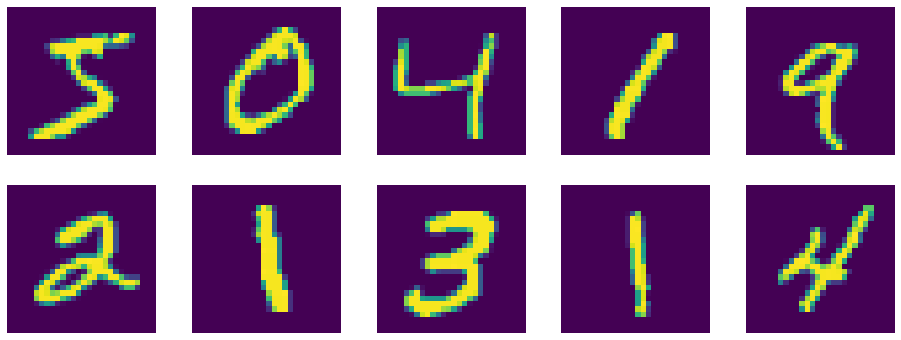

In [10]:
# The MNIST dataset is the handwritten dataset.
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = data.dataset[i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## Create VAE Model

In [11]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Training The Model

In [14]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()

        print(f'====> Epoch: {epoch} Average loss: {loss / len(data.dataset):.4f}')
            
    return autoencoder

In [15]:
latent_dims=2

vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

====> Epoch: 0 Average loss: 0.0699
====> Epoch: 1 Average loss: 0.0701
====> Epoch: 2 Average loss: 0.0641
====> Epoch: 3 Average loss: 0.0666
====> Epoch: 4 Average loss: 0.0582
====> Epoch: 5 Average loss: 0.0637
====> Epoch: 6 Average loss: 0.0659
====> Epoch: 7 Average loss: 0.0582
====> Epoch: 8 Average loss: 0.0625
====> Epoch: 9 Average loss: 0.0598


In [16]:
vae.eval

<bound method Module.eval of VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)>

In [17]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

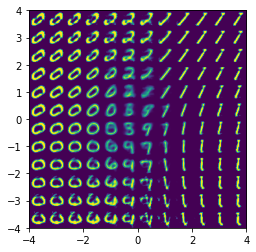

In [18]:
plot_reconstructed(vae, r0=(-4, 4), r1=(-4, 4))

## Visualizing Latent space

In [19]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

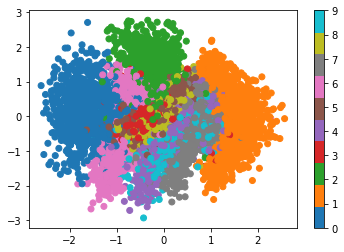

In [20]:
plot_latent(vae, data)

#Interpolate within Latent Space

In [22]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [23]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

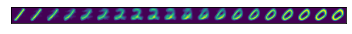

In [24]:
interpolate(vae, x_1, x_2, n=20)

### Implement and Test CVAE

In [26]:
import torch 
import torchvision
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
import torch.nn. functional as F

import os


In [27]:
def load_data():
    transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/', train=True, download=True,
                             transform=transform),batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/', train=False, download=True,
                             transform=transform),batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    return train_loader, test_loader

In [28]:
batch_size = 100
learning_rate = 1e-3
max_epoch = 10
num_workers = 4
load_epoch = -1
generate = True

## Create the model

In [29]:
class CVAE(nn.Module):
    def __init__(self,latent_size=32,num_classes=10):
        super(CVAE,self).__init__()
        self.latent_size = latent_size
        self.num_classes = num_classes

        # For encode
        self.conv1 = nn.Conv2d(2, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(4*4*32,300)
        self.mu = nn.Linear(300, self.latent_size)
        self.logvar = nn.Linear(300, self.latent_size)

        # For decoder
        self.linear2 = nn.Linear(self.latent_size + self.num_classes, 300)
        self.linear3 = nn.Linear(300,4*4*32)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=5,stride=2)
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2)
        self.conv5 = nn.ConvTranspose2d(1, 1, kernel_size=4)

    def encoder(self,x,y):
        y = torch.argmax(y, dim=1).reshape((y.shape[0],1,1,1))
        y = torch.ones(x.shape).to(device)*y
        t = torch.cat((x,y),dim=1)
        
        t = F.relu(self.conv1(t))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))
        
        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(device)
        return eps*std + mu
    
    def unFlatten(self, x):
        return x.reshape((x.shape[0], 32, 4, 4))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = F.relu(self.conv5(t))
        return t


    def forward(self, x, y):
        mu, logvar = self.encoder(x,y)
        z = self.reparameterize(mu,logvar)

        # Class conditioning
        z = torch.cat((z, y.float()), dim=1)
        pred = self.decoder(z)
        return pred, mu, logvar

In [30]:
def loss_function(x, pred, mu, logvar):
    recon_loss = F.mse_loss(pred, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, kld

In [31]:
def train(epoch, model, train_loader, optim):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    for i,(x,y) in enumerate(train_loader):
        try:
            label = np.zeros((x.shape[0], 10))
            label[np.arange(x.shape[0]), y] = 1
            label = torch.tensor(label)

            optim.zero_grad()   
            pred, mu, logvar = model(x.to(device),label.to(device))
            
            recon_loss, kld = loss_function(x.to(device),pred, mu, logvar)
            loss = recon_loss + kld
            loss.backward()
            optim.step()

            total_loss += loss.cpu().data.numpy()*x.shape[0]
            reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
            kld_loss += kld.cpu().data.numpy()*x.shape[0]
            if i == 0:
                print("Gradients")
                for name,param in model.named_parameters():
                    if "bias" in name:
                        print(name,param.grad[0],end=" ")
                    else:
                        print(name,param.grad[0,0],end=" ")
                    print()
        except Exception as e:
            # traceback.print_exe()
            torch.cuda.empty_cache()
            continue
    
    reconstruction_loss /= len(train_loader.dataset)
    kld_loss /= len(train_loader.dataset)
    total_loss /= len(train_loader.dataset)
    return total_loss, kld_loss,reconstruction_loss

In [32]:
def test(epoch, model, test_loader):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    with torch.no_grad():
        for i,(x,y) in enumerate(test_loader):
            try:
                label = np.zeros((x.shape[0], 10))
                label[np.arange(x.shape[0]), y] = 1
                label = torch.tensor(label)

                pred, mu, logvar = model(x.to(device),label.to(device))
                recon_loss, kld = loss_function(x.to(device),pred, mu, logvar)
                loss = recon_loss + kld

                total_loss += loss.cpu().data.numpy()*x.shape[0]
                reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
                kld_loss += kld.cpu().data.numpy()*x.shape[0]
                if i == 0:
                    # print("gr:", x[0,0,:5,:5])
                    # print("pred:", pred[0,0,:5,:5])
                    plot(epoch, pred.cpu().data.numpy(), y.cpu().data.numpy())
            except Exception as e:
                # traceback.print_exe()
                torch.cuda.empty_cache()
                continue
    reconstruction_loss /= len(test_loader.dataset)
    kld_loss /= len(test_loader.dataset)
    total_loss /= len(test_loader.dataset)
    return total_loss, kld_loss,reconstruction_loss

In [33]:
def generate_image(epoch,z, y, model):
    with torch.no_grad():
        label = np.zeros((y.shape[0], 10))
        label[np.arange(z.shape[0]), y] = 1
        label = torch.tensor(label)

        pred = model.decoder(torch.cat((z.to(device),label.float().to(device)), dim=1))
        plot(epoch, pred.cpu().data.numpy(), y.cpu().data.numpy(),name='Eval_')
        print("data Plotted")

In [34]:
def plot(epoch, pred, y,name='test_'):
    if not os.path.isdir('./images'):
        os.mkdir('./images')
    fig = plt.figure(figsize=(16,16))
    for i in range(6):
        ax = fig.add_subplot(3,2,i+1)
        ax.imshow(pred[i,0],cmap='gray')
        ax.axis('off')
        ax.title.set_text(str(y[i]))
    # plt.savefig("./images1/{}epoch_{}.jpg".format(name, epoch))
    plt.figure(figsize=(10,10))
    # plt.imsave("./images/pred_{}.jpg".format(epoch), pred[0,0], cmap='gray')
    plt.close()

In [35]:
def save_model(model, epoch):
    if not os.path.isdir("./checkpoints"):
        os.mkdir("./checkpoints")
    file_name = './checkpoints/model_{}.pt'.format(epoch)
    torch.save(model.state_dict(), file_name)

## Train the model CVAE

dataloader created
model created


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Gradients
conv1.weight tensor([[2.5480, 2.7391, 2.9228, 3.1483, 3.1705],
        [2.6958, 2.9935, 3.1349, 3.2879, 3.3550],
        [2.8258, 3.0451, 3.3295, 3.4005, 3.5146],
        [3.0421, 3.2135, 3.5299, 3.5917, 3.7692],
        [3.0538, 3.3075, 3.5188, 3.6169, 3.6885]]) 
conv1.bias tensor(7.4310) 
conv2.weight tensor([[-0.0151, -0.0133, -0.0157, -0.0161, -0.0129],
        [-0.0168, -0.0165, -0.0205, -0.0164, -0.0133],
        [-0.0157, -0.0153, -0.0165, -0.0172, -0.0135],
        [-0.0169, -0.0169, -0.0164, -0.0188, -0.0128],
        [-0.0167, -0.0195, -0.0205, -0.0180, -0.0120]]) 
conv2.bias tensor(-0.1620) 
linear1.weight tensor(0.0030) 
linear1.bias tensor(5.5238) 
mu.weight tensor(-0.8636) 
mu.bias tensor(-5.2923) 
logvar.weight tensor(3.0706) 
logvar.bias tensor(16.4645) 
linear2.weight tensor(0.3961) 
linear2.bias tensor(0.5272) 
linear3.weight tensor(0.0695) 
linear3.bias tensor(0.5969) 
conv3.weight tensor([[ 2.1497,  0.2390,  1.4616, -0.2495,  1.5542],
        [ 0.1742,  0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


data Plotted
Epoch: 9/10 Train loss: 2980.330709228516, Train KLD: 442.5239952596029, Train Reconstruction Loss:2537.8067138671877
Epoch: 9/10 Test loss: 2564.9425219726563, Test KLD: 433.8406948852539, Test Reconstruction Loss:2564.9425219726563


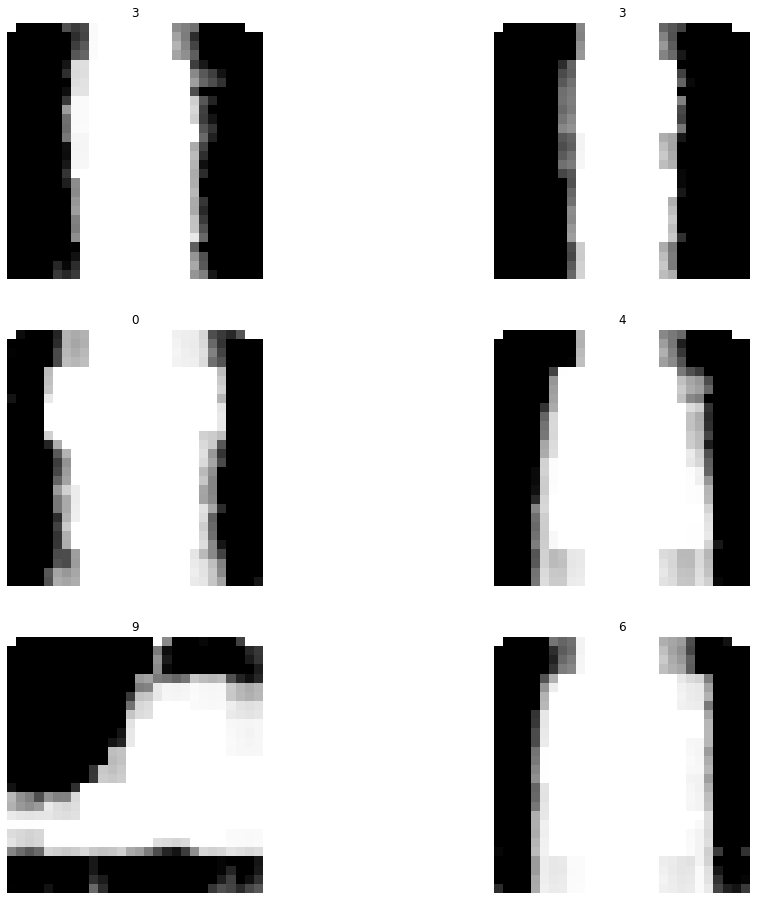

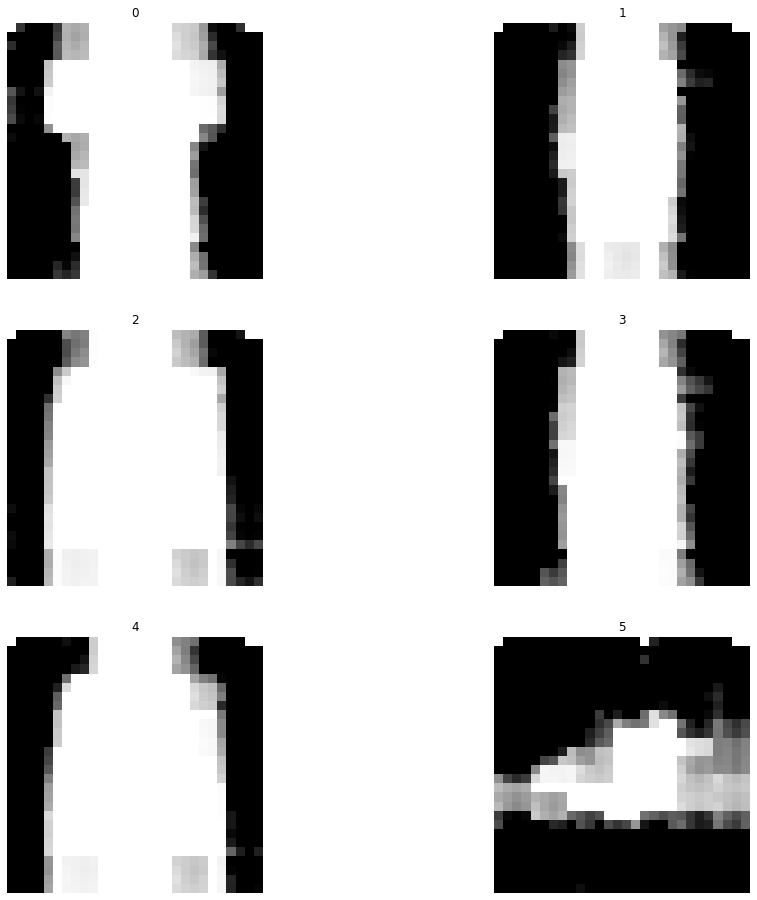

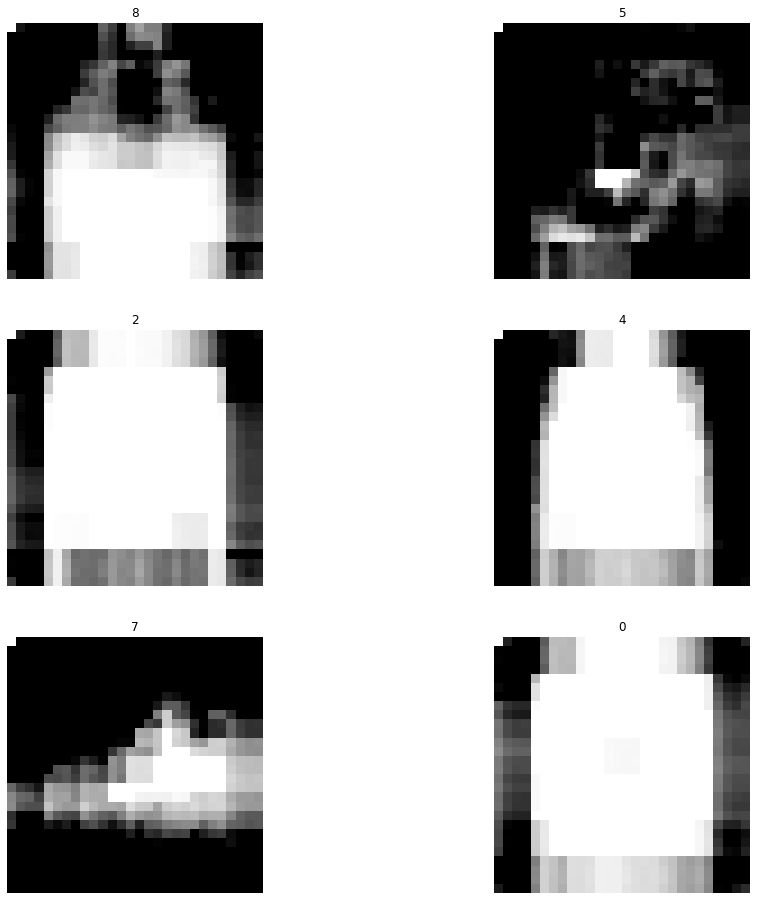

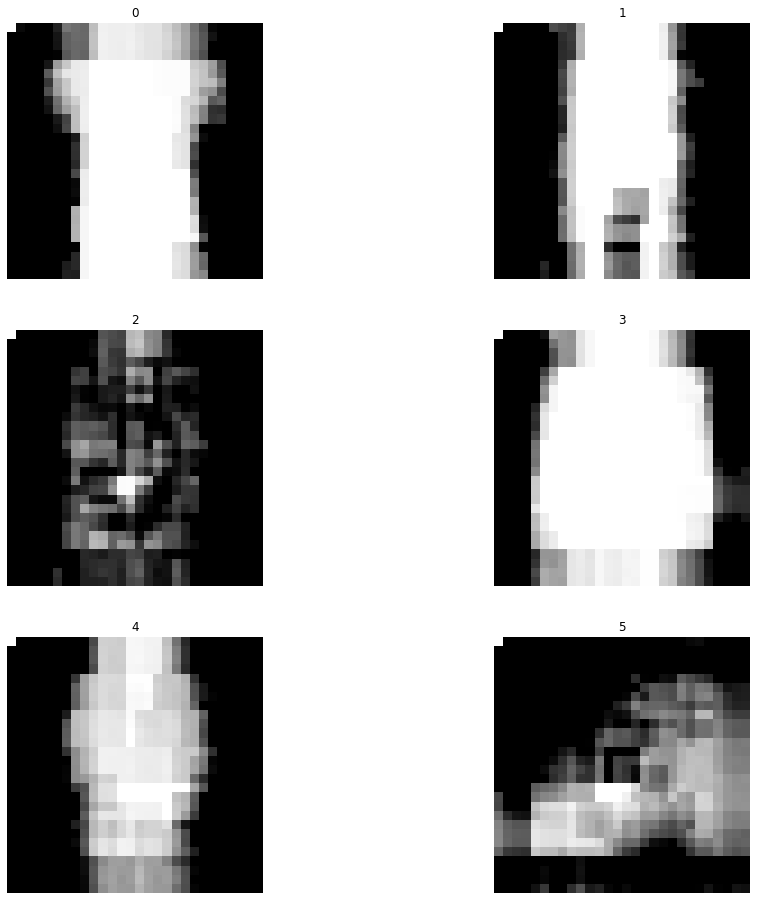

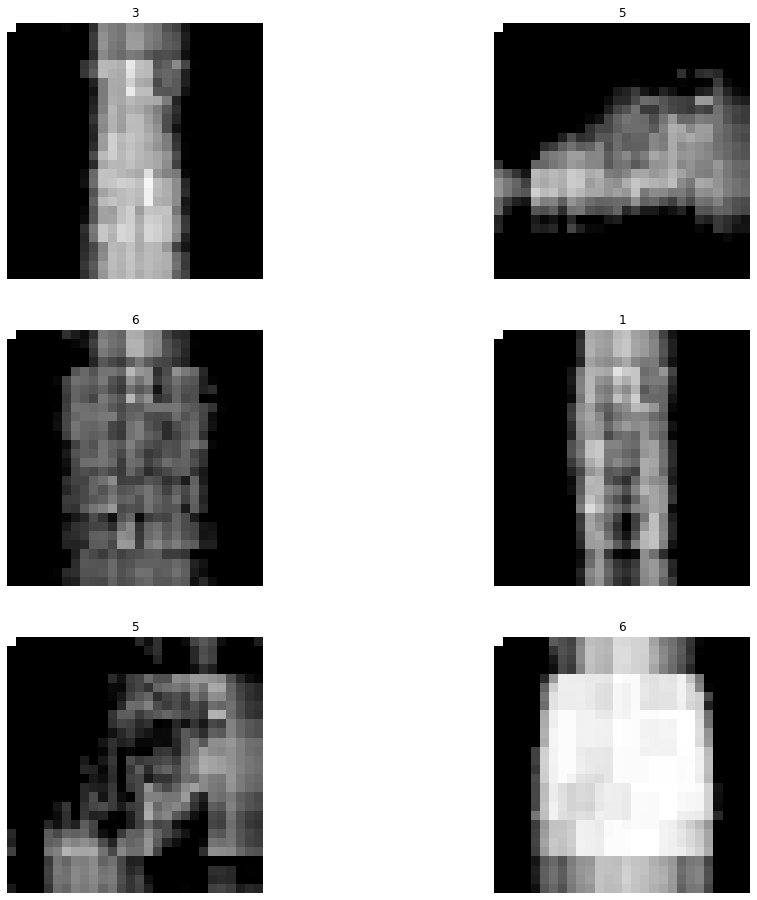

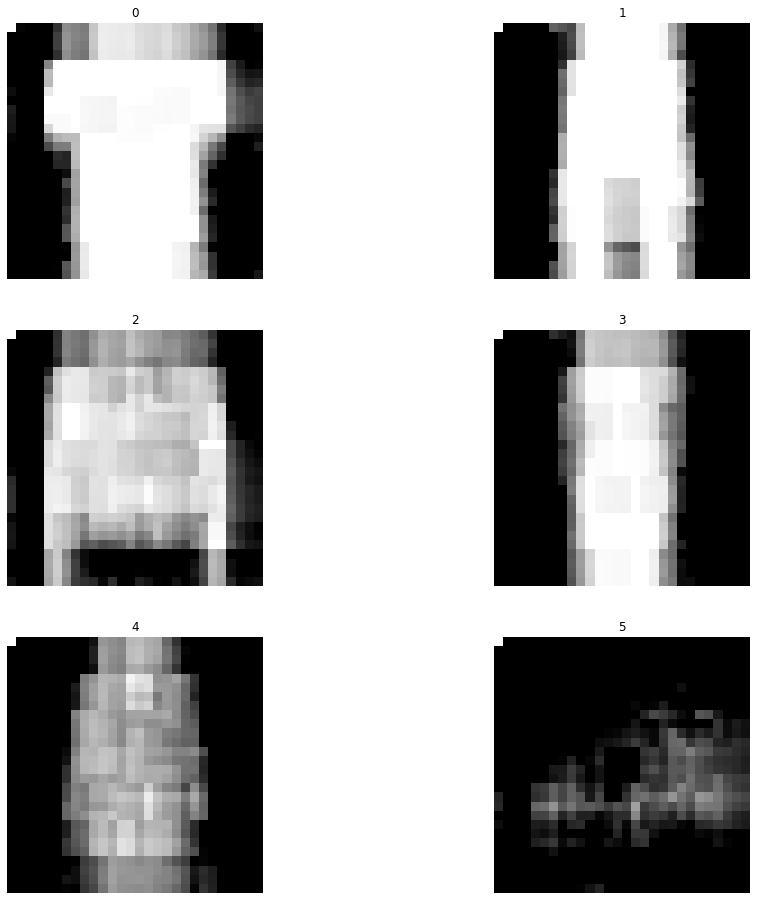

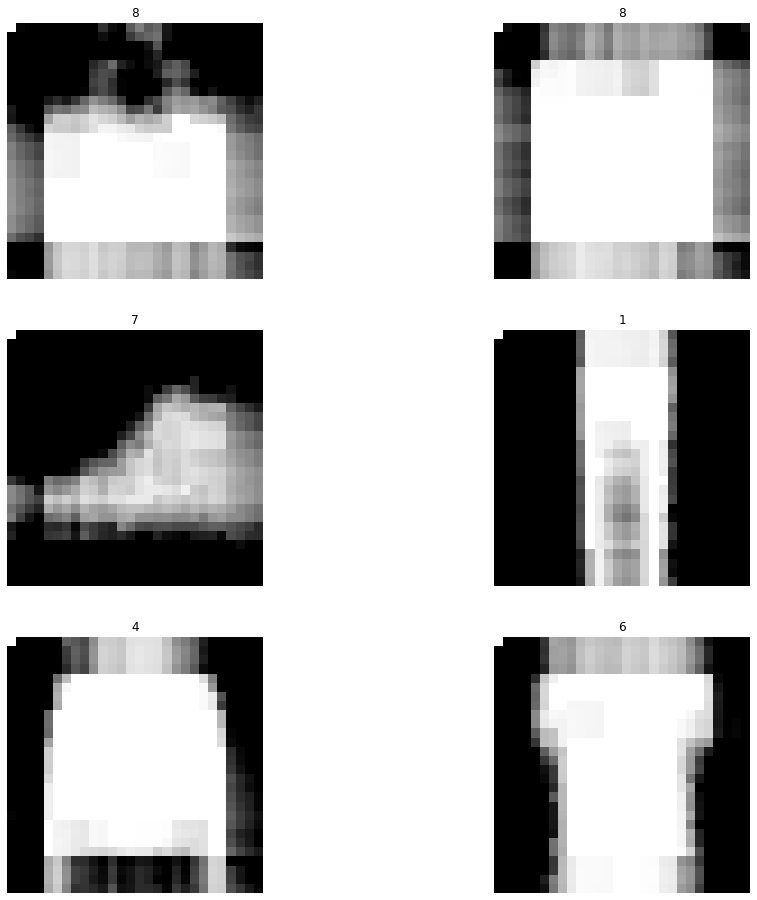

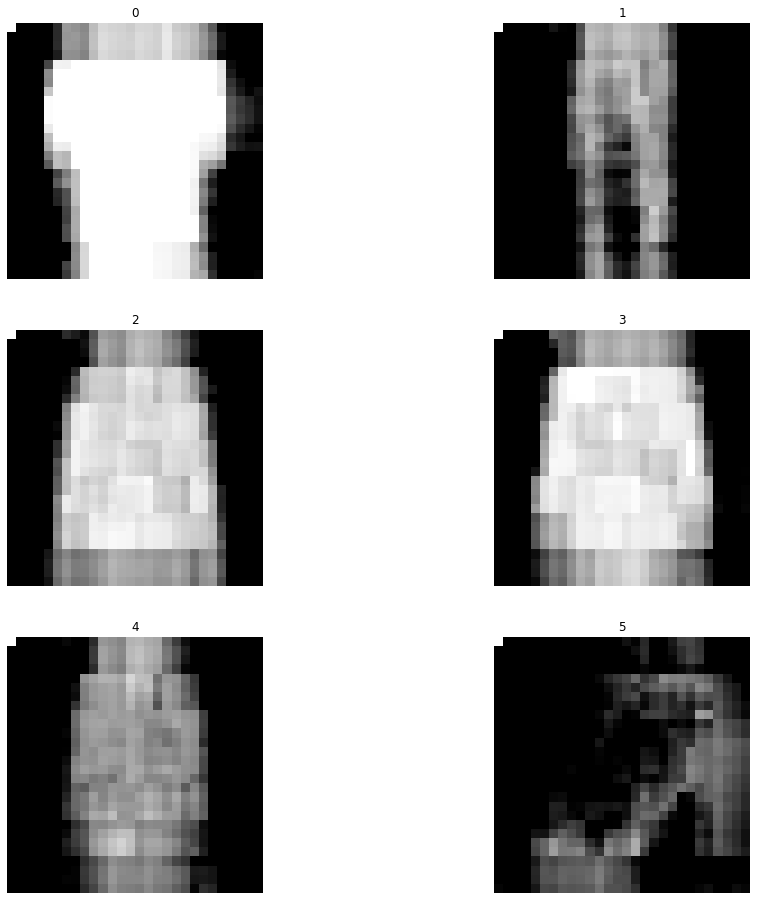

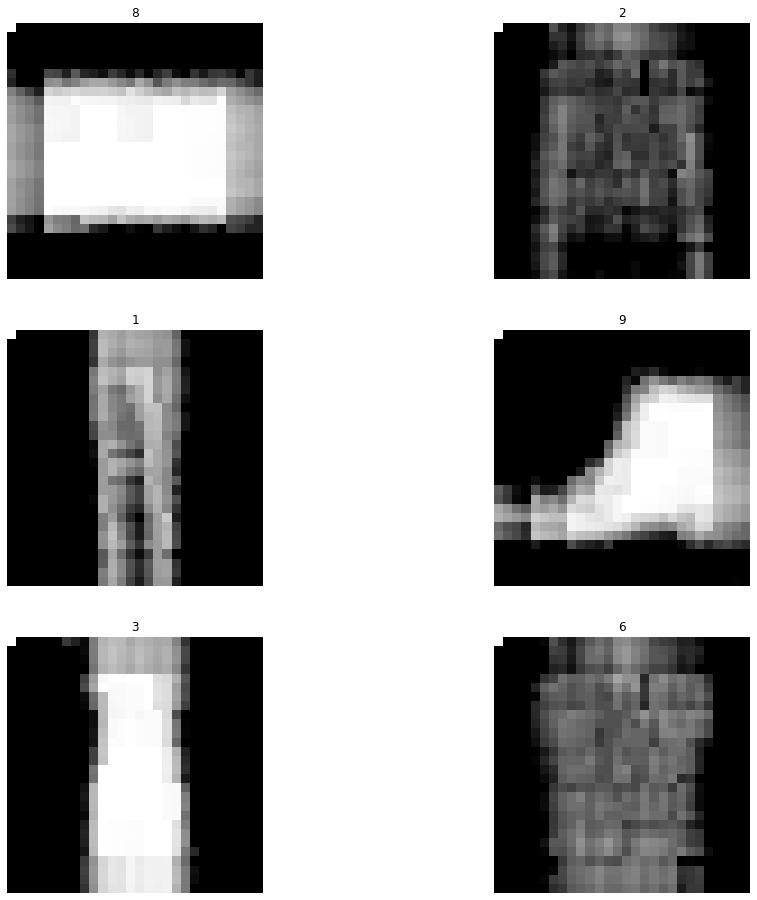

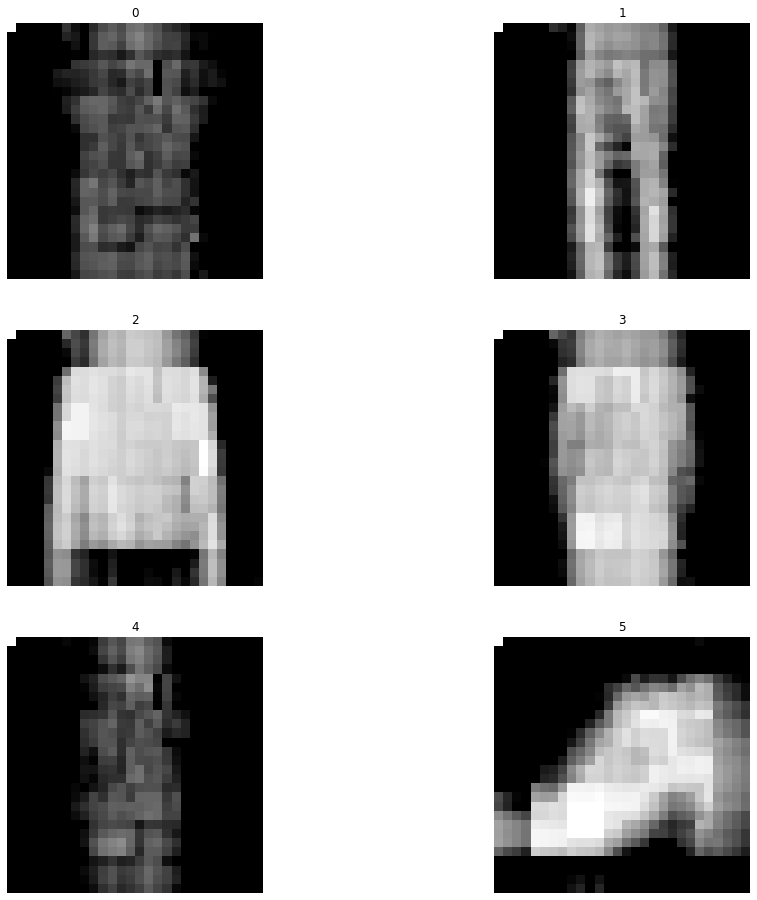

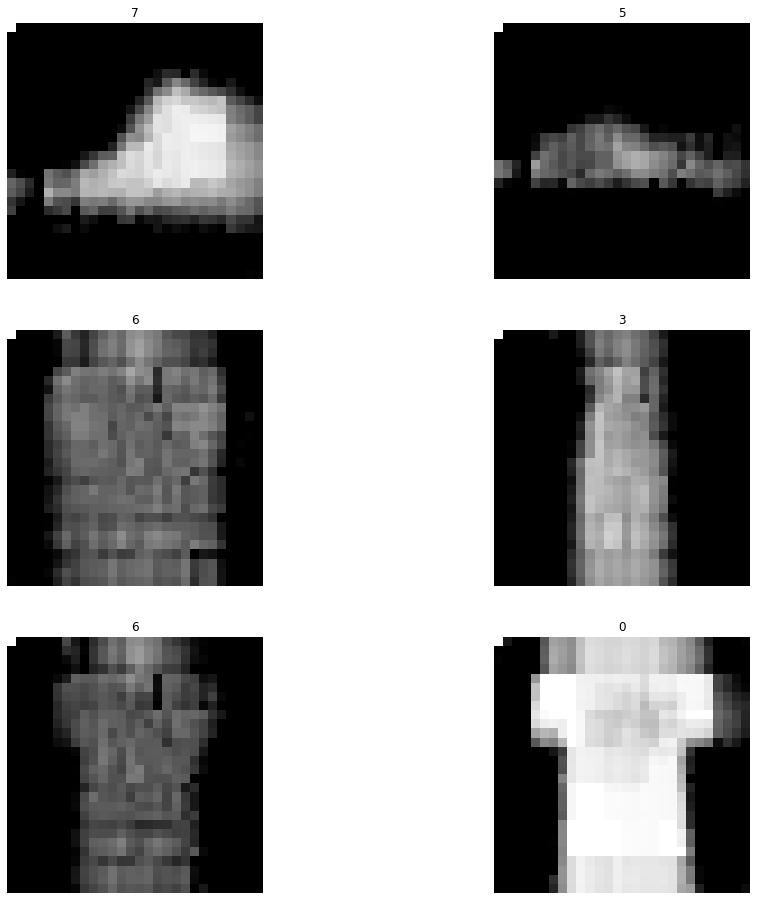

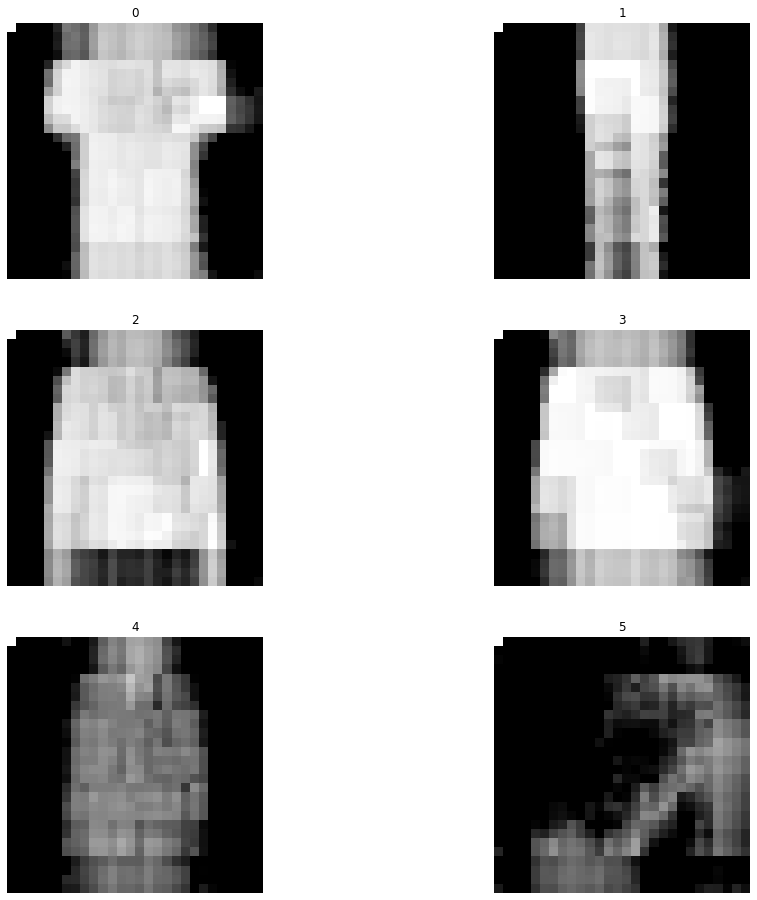

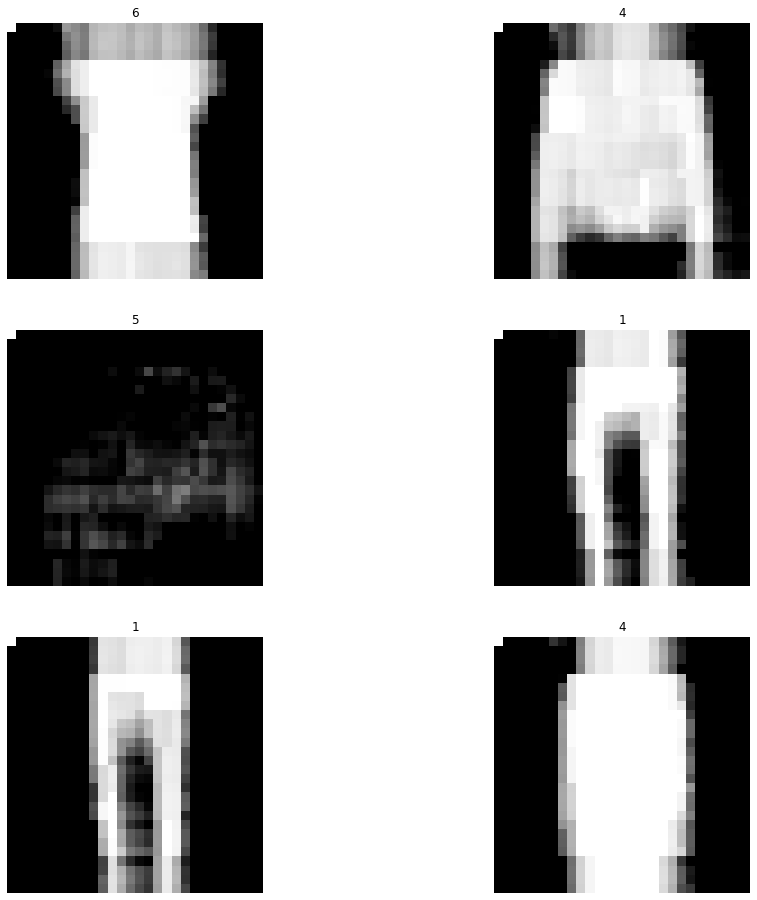

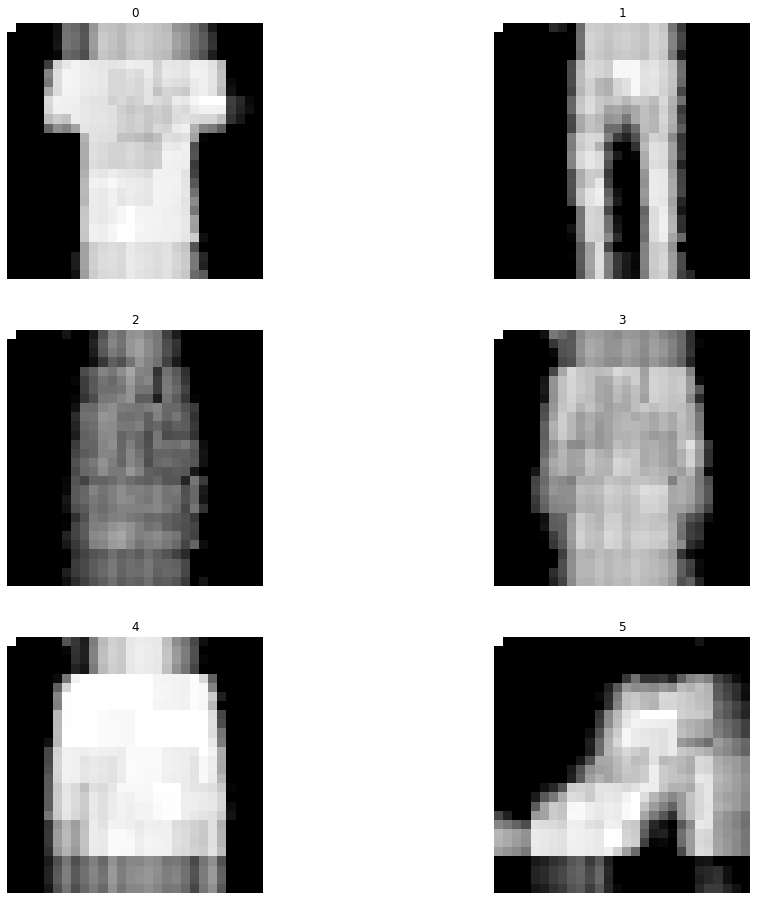

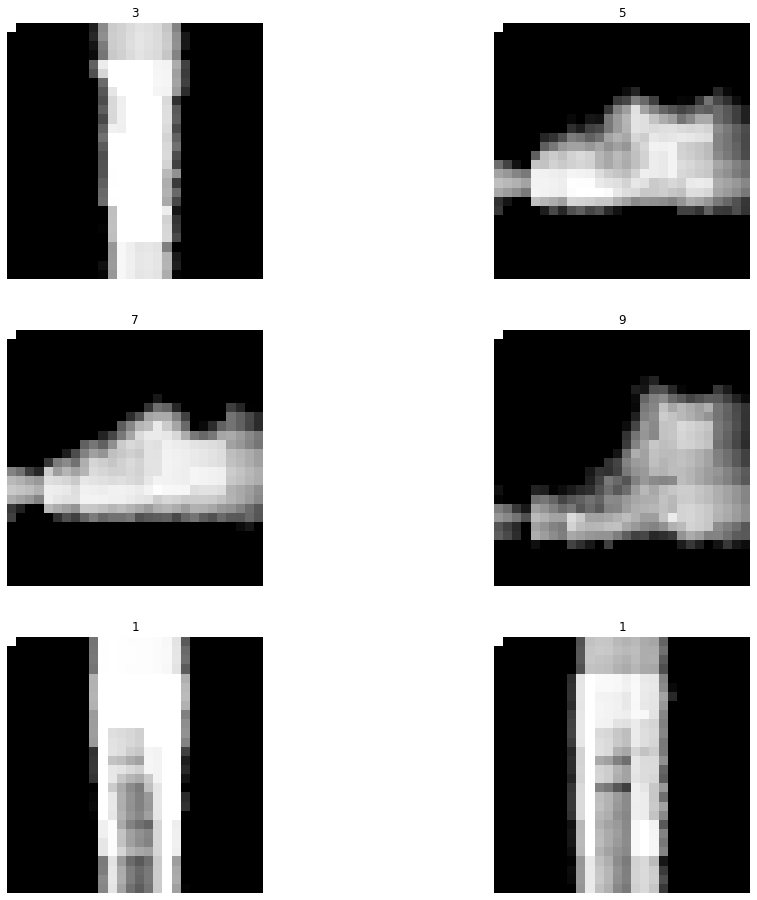

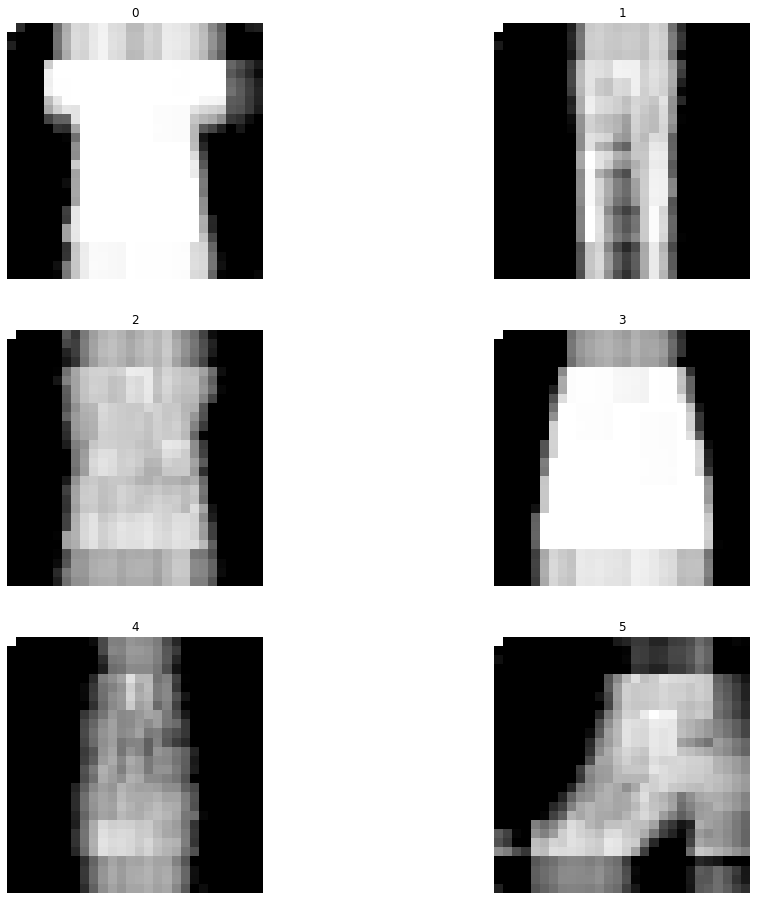

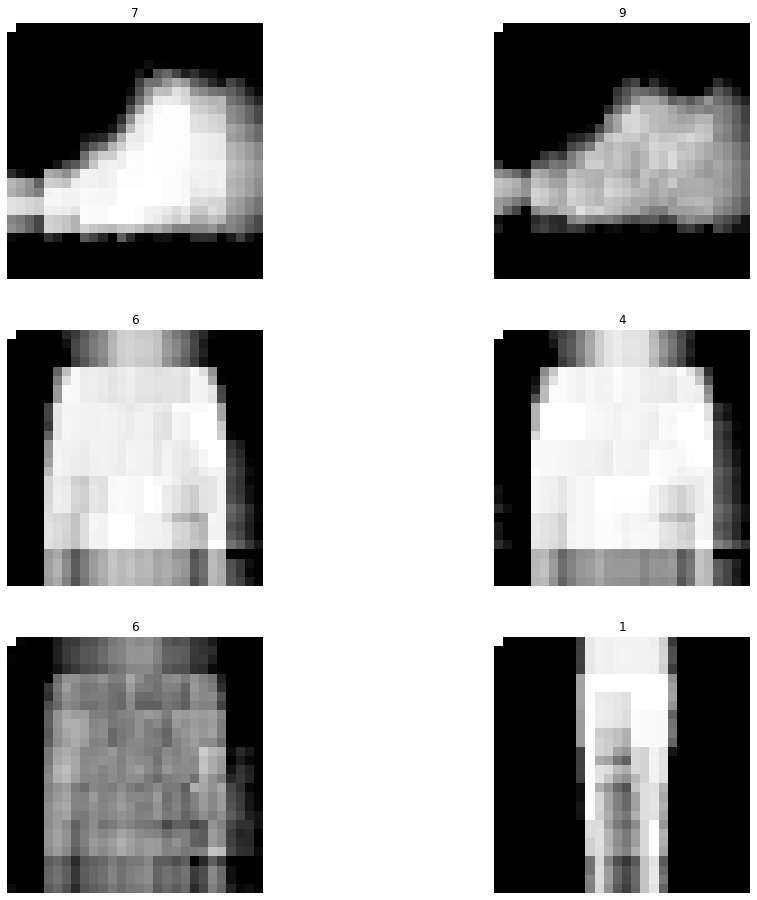

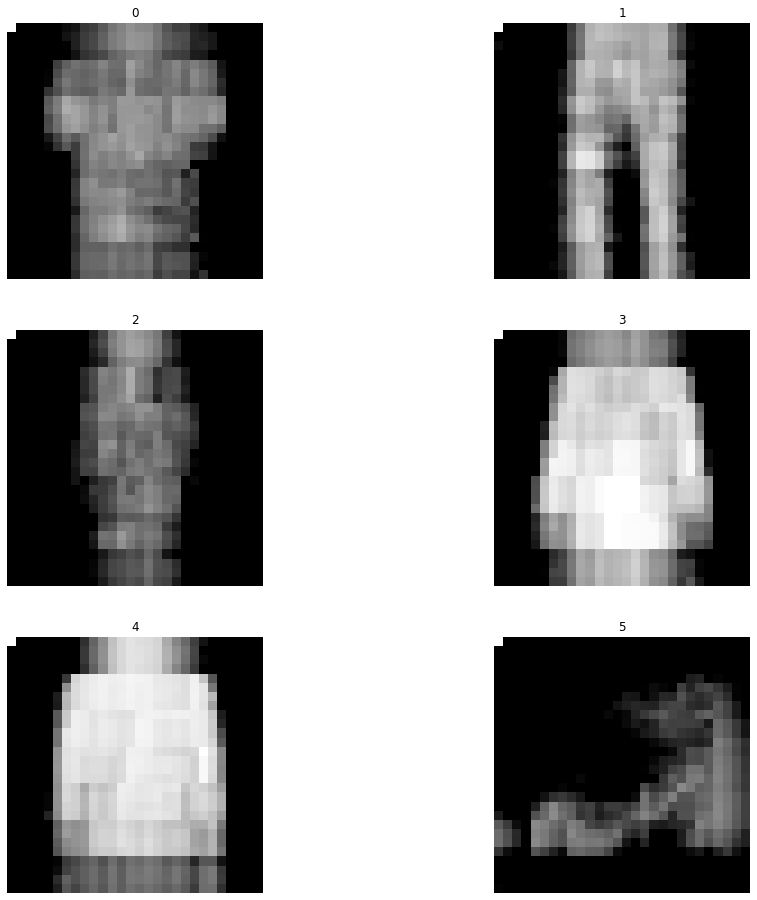

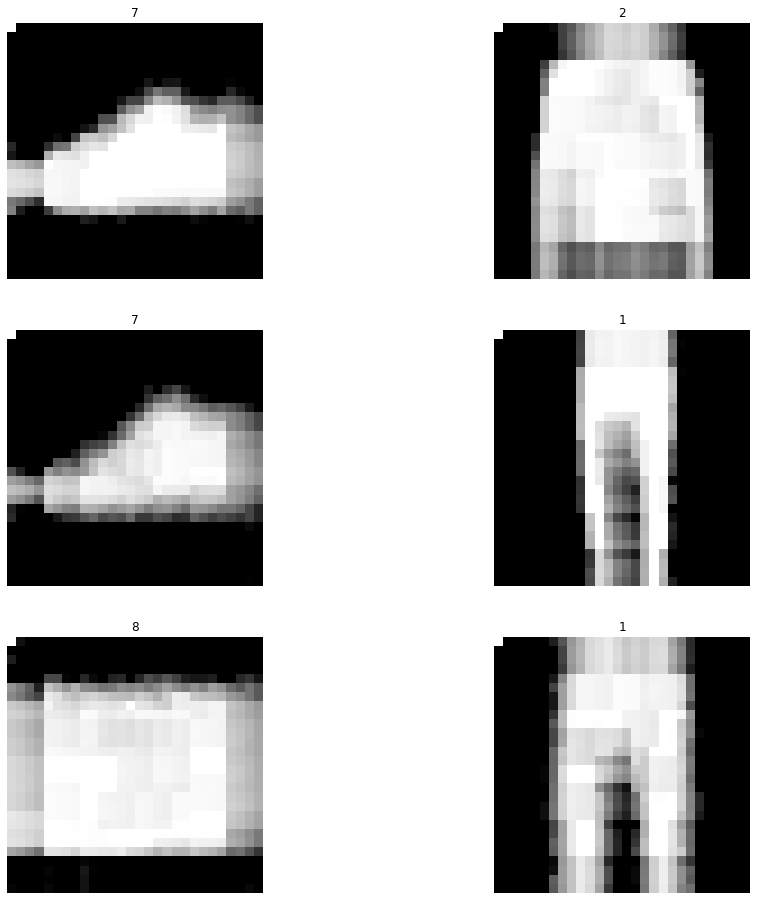

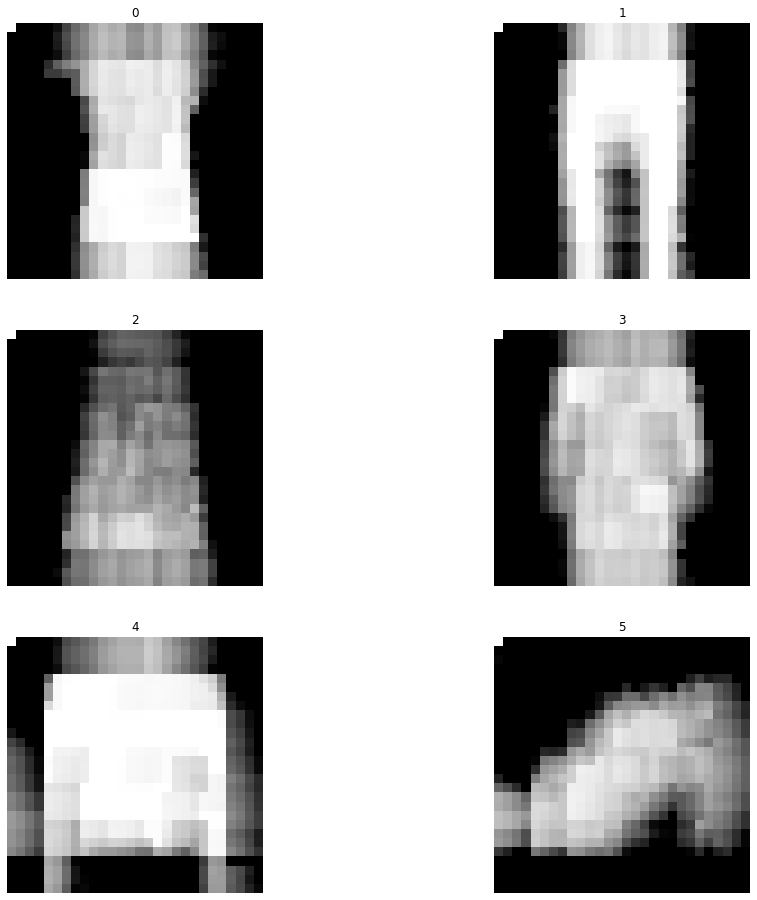

In [36]:
if __name__ == "__main__":
    train_loader, test_loader = load_data()
    print("dataloader created")
    model = CVAE().to(device)
    model.eval
    print("model created")
    
    if load_epoch > 0:
        model.load_state_dict(torch.load('./checkpoints/model_{}.pt'.format(load_epoch), map_location=torch.device('cpu')))
        #print("model {} loaded".format(load_epoch))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)


    train_loss_list = []
    test_loss_list = []
    for i in range(load_epoch+1, max_epoch):
        model.train()
        train_total, train_kld, train_loss = train(i, model, train_loader, optimizer)
        with torch.no_grad():
            model.eval()
            test_total, test_kld, test_loss = test(i, model, test_loader)
            if generate:
                z = torch.randn(6, 32).to(device)
                y = torch.tensor([1,2,3,4,5,6]) - 1
                generate_image(i,z, y, model)
            
        print("Epoch: {}/{} Train loss: {}, Train KLD: {}, Train Reconstruction Loss:{}".format(i, max_epoch,train_total, train_kld, train_loss))
        print("Epoch: {}/{} Test loss: {}, Test KLD: {}, Test Reconstruction Loss:{}".format(i, max_epoch, test_loss, test_kld, test_loss))
        

        save_model(model, i)
        train_loss_list.append([train_total, train_kld, train_loss])
        test_loss_list.append([test_total, test_kld, test_loss])
        np.save("train_loss", np.array(train_loss_list))
        np.save("test_loss", np.array(test_loss_list))